# Using python to search and download Water Prediction Node data

In this tutorial we will demonstrate how to filter, import, and visualize satellite imagery hosted by the Water Prediction Node using the SpatioTemporal Asset Catalog (STAC) api. 

## What is a STAC catalog?

Every day satellite's collect terabytes of data. It is impractical and not desirable in most cases to access most of this data. Metadata specifications that allow a user to filter these large datesets down to just the data of interest for a given application can be immensely valuable when trying to query satellite data. 

The SpatioTemporal Asset Catalog (STAC) is one such specification. It is a metadata specifiaction that allows data providers to create a catalog of data that can then be programatically filtered and downloaded using a STAC client.

The Water Prediction Node data catalog is a STAC catalog that can be interacted with via the [Water Node graphical browser](https://waternode.ciroh.org/catalog/)

## Querying the earth search STAC catalog
We will now query the Water Node catalog for 1-day VIIRS composite flood maps stored as Cloud Optimized GeoTIFF (COG) files. A COG is a a raster data format that is optimized for being hosted on cloud services. The COG format is based on the normal georeferenced GeoTIFF file format but organizes the data so that partial data access is possible using HTTP range requests. Partial data reads and writes make it so that large satellite images don't have to be transferred in their entirety when only a subset of the data is needed. COG's also have the ability to store lower resolution versions of an image as overlays on top of the original resolution. This pyramidal structure is another feature that prevents having to deal with massive unneccessary data transfers.  

In [4]:
#import the pystac STAC client to work with the Water Node STAC catalog
import pystac

# import the Water Node public STAC catalog
catalog_url = 'https://fim-public.s3.amazonaws.com/catalog.json'
catalog = pystac.Catalog.from_file(catalog_url)

# Print details of the first item
print(f"ID: {first_item.id}")
print(f"Date: {first_item.datetime}")
print(f"Assets: {list(first_item.assets.keys())}")

ID: RIVER-FLDglobal-composite1_20230825_000000.part133.tif
Date: 2023-08-25 00:00:00+00:00
Assets: ['thumbnail', 'image']


In [3]:
#Let's inspect the metadata in the item we just gathered
print(first_item,"\n")

<Item id=RIVER-FLDglobal-composite1_20230825_000000.part133.tif> 



## Accessing the assets contained in the item

In [4]:
asset = item.assets

In [5]:
for key, asset in asset.items():
    print(f"{key}: {asset['title']}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [6]:
# refresh asset dictionary
asset = item.assets

# print thumnail properties
print(asset['thumbnail'])

{'title': 'Thumbnail', 'type': 'image/png', 'roles': ['thumbnail'], 'href': 'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2023/5/2/0/preview.jpg'}


In [7]:
# Get the download link for the thumbnail image
asset["thumbnail"]['href']

'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2023/5/2/0/preview.jpg'

## Accessing raster data

Now let's access some rasterdata. We will use the rioxarray library.

In [8]:
import rioxarray
b01_href = asset["B01"]['href']
b01 = rioxarray.open_rasterio(b01_href)
print(b01)

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


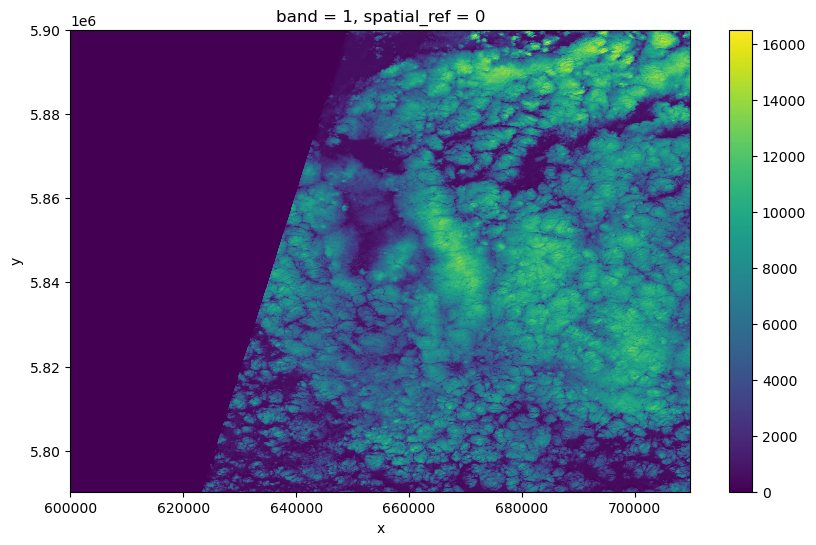

In [9]:
# Plot the raster image
import matplotlib.pyplot as plt

# Plot the raster data
fig, ax = plt.subplots(figsize=(10, 6))
b01[0,:,:].plot.imshow(ax=ax, cmap='viridis')
plt.show()

In [10]:
# Save the raster image to disk
b01.rio.to_raster("B01.tif")

## Viewing other raster properties

In [11]:
#Coordinate reference system
print(b01.rio.crs)
#Areas with no data
print(b01.rio.nodata)
#image bounds
print(b01.rio.bounds())
#image size
print(b01.rio.width)
print(b01.rio.height)

EPSG:32631
0
(600000.0, 5790240.0, 709800.0, 5900040.0)
1830
1830


We can query the coordinate reference system in more depth

In [12]:
from pyproj import CRS
epsg = b01.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

* Name of the projection is UTM zone 31N (UTM has 60 zones, each 6-degrees of longitude in width). 
* The underlying datum is WGS84.
* Axis Info: the CRS shows a Cartesian system with two axes, easting and northing, in meter units.
* Area of Use: the projection is used for a particular range of longitudes 0°E to 6°E in the northern hemisphere (0.0°N to 84.0°N)
* Coordinate Operation: the operation to project the coordinates (if it is projected) onto a cartesian (x, y) plane. Transverse Mercator is accurate for areas with longitudinal widths of a few degrees, hence the distinct UTM zones.
* Datum: Details about the datum, or the reference point for coordinates. WGS 84 and NAD 1983 are common datums. NAD 1983 is set to be replaced in 2022.


## Calculating raster statistics

In [13]:
print(b01.min())
print(b01.max())
print(b01.mean())
print(b01.std())

<xarray.DataArray ()>
array(0, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(16514, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(3717.0427185)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(3657.10622843)
Coordinates:
    spatial_ref  int64 0


We could also do this with numpy

In [15]:
import numpy as np
print(np.min(b01))
print(np.max(b01))
print(np.mean(b01))
print(np.std(b01))

<xarray.DataArray ()>
array(0, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(16514, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(3717.0427185)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(3657.10622843)
Coordinates:
    spatial_ref  int64 0


## Using rioxarray to mask "nodata" values

When we inspected the band 1 raster we saw that the value that represents a "nodata" reading is zero. Sometimes we want "nodata" to be set to nan so that we know to exclude it from an analysis. Let's load a different band and set the "masked" argument to true. This will set the "nodata" value from 0 to NaN. This is helpful if you don't want to include "nodata" values in your analysis.

In [17]:
b9 = rioxarray.open_rasterio(asset["B09"]['href'], masked=True)

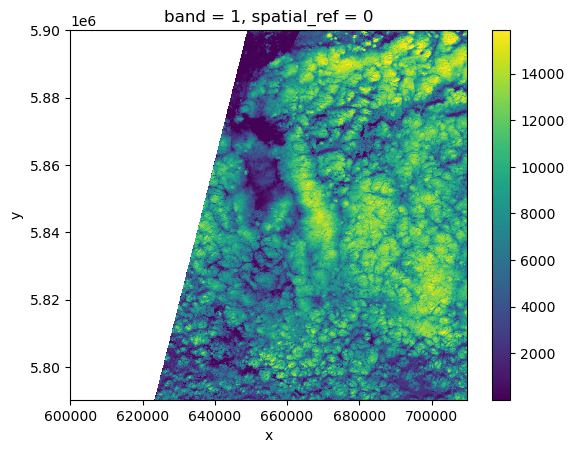

In [18]:
#lets plot. Notice how now the values on the left side of the image aren't plotted
b9.plot()

## Using vector data to crop raster data

Earlier we used a point geometry to filter out the Sentinel 2 collection to only include scenes that intersected a point. Vector geometries can interact with raster data in other ways and we'll explore using vectors to crop raster data and to calculate raster statistics wihin certain zones delineated by vector data.

Before doing this let's do:

### a quick introduction to the python libraries shapely and geopandas.

In [ ]:
import geopandas as gpd
